<a href="https://colab.research.google.com/github/kina19131/ECE324/blob/main/MP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from torch.functional import Tensor
from __future__ import print_function
from collections import defaultdict
from itertools import count
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions
from torch.autograd import Variable


import matplotlib.pyplot as plt

class Environment(object):
    """
    The Tic-Tac-Toe Environment
    """
    # possible ways to win
    win_set = frozenset([(0,1,2), (3,4,5), (6,7,8), # horizontal
                         (0,3,6), (1,4,7), (2,5,8), # vertical
                         (0,4,8), (2,4,6)])         # diagonal
    # statuses
    STATUS_VALID_MOVE = 'valid'
    STATUS_INVALID_MOVE = 'inv'
    STATUS_WIN = 'win'
    STATUS_TIE = 'tie'
    STATUS_LOSE = 'lose'
    STATUS_DONE = 'done'

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset the game to an empty board."""
        self.grid = np.array([0] * 9) # grid
        self.turn = 1                 # whose turn it is
        self.done = False             # whether game is done
        return self.grid

    def render(self):
        """Print what is on the board."""
        map = {0:'.', 1:'x', 2:'o'} # grid label vs how to plot
        print(''.join(map[i] for i in self.grid[0:3]))
        print(''.join(map[i] for i in self.grid[3:6]))
        print(''.join(map[i] for i in self.grid[6:9]))
        print('====')

    def check_win(self):
        """Check if someone has won the game."""
        for pos in self.win_set:
            s = set([self.grid[p] for p in pos])
            if len(s) == 1 and (0 not in s):
                return True
        return False

    def step(self, action):
        """Mark a point on position action."""
        ## assert type(action) == int and action >= 0 and action < 9
        assert isinstance(action, (int, Tensor)) and action >= 0 and action < 9

        # done = already finished the game
        if self.done:
            return self.grid, self.STATUS_DONE, self.done
        # action already have something on it
        if self.grid[action] != 0:
            return self.grid, self.STATUS_INVALID_MOVE, self.done
        # play move
        self.grid[action] = self.turn
        if self.turn == 1:
            self.turn = 2
        else:
            self.turn = 1
        # check win
        if self.check_win():
            self.done = True
            return self.grid, self.STATUS_WIN, self.done
        # check tie
        if all([p != 0 for p in self.grid]):
            self.done = True
            return self.grid, self.STATUS_TIE, self.done
        return self.grid, self.STATUS_VALID_MOVE, self.done

    def random_step(self):
        """Choose a random, unoccupied move on the board to play."""
        pos = [i for i in range(9) if self.grid[i] == 0]
        move = random.choice(pos)
        return self.step(move)

    def play_against_random(self, action):
        """Play a move, and then have a random agent play the next move."""
        state, status, done = self.step(action)
        if not done and self.turn == 2:
            state, s2, done = self.random_step()
            if done:
                if s2 == self.STATUS_WIN:
                    status = self.STATUS_LOSE
                elif s2 == self.STATUS_TIE:
                    status = self.STATUS_TIE
                else:
                    raise ValueError("???")
        return state, status, done

class Policy(nn.Module):
    """
    The Tic-Tac-Toe Policy
    """
    def __init__(self, input_size=27, hidden_size=64, output_size=9):
        super(Policy, self).__init__()
        self.layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        # TODO
        # pass

    def forward(self, x):
        # TODO
        # pass
        x = self.layer(x)
        x = torch.relu(x)

        x = self.output_layer(x) 
        x = torch.sigmoid(x)
        return(x)

def select_action(policy, state):
    """Samples an action from the policy at the state."""
    state = torch.from_numpy(state).long().unsqueeze(0)
    state = torch.zeros(3,9).scatter_(0,state,1).view(1,27)
    pr = policy(Variable(state))
    m = torch.distributions.Categorical(pr) 
    action = m.sample()
    log_prob = torch.sum(m.log_prob(action))
    #return action.data[0], log_prob
    return action.data.numpy().tolist()[0], log_prob

def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
      @param rewards: list of floats, where rewards[t] is the reward
                      obtained at time step t
      @param gamma: the discount factor
      @returns list of floats representing the episode's returns
          G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... 

    >>> compute_returns([0,0,0,1], 1.0)
    [1.0, 1.0, 1.0, 1.0]
    >>> compute_returns([0,0,0,1], 0.9)
    [0.7290000000000001, 0.81, 0.9, 1.0]
    >>> compute_returns([0,-0.5, 5, 0.5,-10], 0.9)
    [-2.5965000000000003, -2.8850000000000002, -2.6500000000000004, -8.5, -10.0]
    """
    # TODO
    episode_return = [] 
    G_t = 0
    r_t = 0 
    rewards.reverse()
    for i in range(len(rewards)): 
      r_t = rewards[i] 
      if i==0: 
        G_t = float(r_t)
      else:
        G_t = r_t + gamma*G_t
      episode_return.append(G_t)
    
    episode_return.reverse()
    
    return(episode_return)


def finish_episode(saved_rewards, saved_logprobs, gamma=1.0):
    """Samples an action from the policy at the state."""
    
    policy_loss = []
    returns = compute_returns(saved_rewards, gamma)
    returns = torch.Tensor(returns)
    # subtract mean and std for faster training
    returns = (returns - returns.mean()) / (returns.std() +
                                            np.finfo(np.float32).eps)
    for log_prob, reward in zip(saved_logprobs, returns):
        #policy_loss.append(-log_prob * reward)
        policy_loss.append(-log_prob * reward.view(1, 1))
    policy_loss = torch.stack(policy_loss).sum()
    policy_loss.backward(retain_graph=True)
    # note: retain_graph=True allows for multiple calls to .backward()
    # in a single step

def get_reward(status):
    """Returns a numeric given an environment status."""
    return {
            Environment.STATUS_VALID_MOVE  : 0, # TODO
            Environment.STATUS_INVALID_MOVE: -1,
            Environment.STATUS_WIN         : 20,
            Environment.STATUS_TIE         : 15,
            Environment.STATUS_LOSE        : -10
    }[status]

def train(policy, env, gamma=1.0, log_interval=1000):
    """Train policy gradient."""
    #optimizer = optim.Adam(policy.parameters(), lr=0.001)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
    optimizer = optim.Adam(policy.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10000, gamma=0.9)
    running_reward = 0

    # ADDED VARIABLES
    EPOCHS = 55000
    batch_size = 10
    avg = [] 

    for i_episode in range(EPOCHS):
        saved_rewards = []
        saved_logprobs = []
        state = env.reset()
        done = False
        while not done:
            action, logprob = select_action(policy, state)
            state, status, done = env.play_against_random(action)
            reward = get_reward(status)
            saved_logprobs.append(logprob)
            saved_rewards.append(reward)

        R = compute_returns(saved_rewards)[0]
        running_reward += R

        finish_episode(saved_rewards, saved_logprobs, gamma)

        if i_episode % log_interval == 0:
            print('Episode {}\tAverage return: {:.2f}'.format(
                i_episode,
                running_reward / log_interval))
            avg.append(running_reward / log_interval)
            running_reward = 0

        if i_episode % (log_interval) == 0:
            torch.save(policy.state_dict(),
                       "policy-%d.pkl" % i_episode)

        if i_episode % 1 == 0: # batch_size
        #if i_episode % batch_size:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
    print()
    print("Best:", max(avg))
    print("Mean:", np.mean(avg))
    print()
    
    plt.title("Episodes vs Average")
    plt.plot(avg, label="Average")
    plt.xlabel("Episodes(k)")
    plt.ylabel("Average")
    plt.legend(loc='best')
    plt.show()

    

def first_move_distr(policy, env):
    """Display the distribution of first moves."""
    state = env.reset()
    state = torch.from_numpy(state).long().unsqueeze(0)
    state = torch.zeros(3,9).scatter_(0,state,1).view(1,27)
    pr = policy(Variable(state))
    return pr.data


def load_weights(policy, episode):
    """Load saved weights"""
    weights = torch.load("policy-%d.pkl" % episode)
    policy.load_state_dict(weights)



# **Part1: Environment**

>How is the grid represented? 
- The grid is represented as an empty array. Thereby the positions where a player make moves are indexed with 0~8. 

>What do the attributes turn and done represent?
- The 'turn' represents which player will make a move.  
- 'done' is there to check if the game has terminated. Either there is a winner or there is a tie, however the game is over. 

In [ ]:
'''
Create a new environment, and play a game of Tic-Tac-Toe against yourself 
by calling the step(), and render() methods. Display the text output in your report.
'''
if __name__ == '__main__':
    env = Environment()

    env.render()
    print("\n")
    env.step(4)
    env.render()
    print("\n")

    env.step(2)
    env.render()
    print("\n")

    env.step(8)
    env.render()
    print("\n")

    env.step(3)
    env.render()
    print("\n")
    
    env.step(0)
    env.render()
    print("\n")

    print("There is a winner?",env.check_win())


...
...
...
====


...
.x.
...
====


..o
.x.
...
====


..o
.x.
..x
====


..o
ox.
..x
====


x.o
ox.
..x
====


There is a winner? True


#**Part2: Policy**


**Part 2(a)**<br>
>The Policy class is incomplete. Complete the implementation so that your policy is a neural network with one hidden layer. **[checked]** 

<br>**Part 2(b)**<br> 
>Tic-Tac-Toe has a 3x3 grid. However there are three possible states: x player, o player, and an empty board. Therfore for the three different states each get the 3x3 grid. As a result there are 3x3x3, 27 dimensions. 

<br>**Part 2(c)**<br>
>Each dimension of the output 9-dimensional vector represents the 9 different positions on the 3x3 game board of Tic-Tac-Toe. The 9-dimentional output vector is the new position of the current player after it's move. 

>This policy is Stochastic. 

# **Part3: Policy Gradient**

In [ ]:
'''
Part3 (a)
'''
ret = compute_returns([0,0,0,1], 1.0)
print(ret)
# provided solution: [1.0, 1.0, 1.0, 1.0]

ret = compute_returns([0,0,0,1], 0.9)
print(ret)
# provided solution: [0.7290000000000001, 0.81, 0.9, 1.0]

ret = compute_returns([0,-0.5, 5, 0.5,-10], 0.9)
print(ret)
# provided solution: [-2.5965000000000003, -2.8850000000000002, -2.6500000000000004, -8.5, -10.0]

[1.0, 1.0, 1.0, 1.0]
[0.7290000000000001, 0.81, 0.9, 1.0]
[-2.5965000000000003, -2.8850000000000002, -2.6500000000000004, -8.5, -10.0]


**part3 (b)**
<br>

>We cannot compute the backward pass to update weights until the entire episode is complete. This is because we need to observe the whole squence of the actions before updating the weights. For the games like Tic-Tac-Toe, We do not know what the optimal is after each action. Only after the entire episode, depending on the win or lose, the model can learn. 

# **PART4: Rewards**

Part 4(a) <br>

Modify the get_reward function to what you think the reward should be to be able to train the policy to play Tic-Tac-Toe.

**[checked]**

Part 4(b) <br>
*Choosen* <br>
>Environment.STATUS_VALID_MOVE  : 0, <br>
Environment.STATUS_INVALID_MOVE: -1, <br>
Environment.STATUS_WIN         : 20, <br>
Environment.STATUS_TIE         : 15, <br>
Environment.STATUS_LOSE        : -10 <br>

I gave a negative reward (-1) for the invalid move. Through the penalty, it should learn that doing so is bad and should learn to not make invalid moves. On the otherhand, I did not reward any for the valid move because I assumed this should be the "default" state - being able to make a valid movements is a base requirement. Then for the training purposes, I penalized 'Lose' while I rewarded 'Tie' and 'Win'. The purpose of this lab is to use machine learning to build a model that can "win" the game. Therefore, to fullfill the objective, 'Lose' had to be penalized. On the other hand, 'Win' was rewarded so that the machine will learn and try to earn the positive rewards. To favoritize the 'Win', I have heavily weighted the 'Win' reward. Then by logical sense, I gave a lower reward for the 'Tie'. 'Tie' is better than the 'Lose' and also it is in a sense a 'Win' for the both players, instead of penalizing, I used soft margin to reward it. 

# **Part 5: Training**

**Part 5 (a)**<br>
Clearly indicate if you have changed any hyperparameters and why.<br>
>I have decreased the learning rate to 0.0001 from 0.001. The bigger learning rate had faster training time but the graph was extra noisy with a lot of ups and downs. Therefore, I decided to make the learning rate slightly smaller since it may help the model learn more optimal set of weights while sacrifising the training time. 

Episode 0	Average return: -0.01
Episode 1000	Average return: 4.31
Episode 2000	Average return: 5.62
Episode 3000	Average return: 4.84
Episode 4000	Average return: 5.92
Episode 5000	Average return: 5.79
Episode 6000	Average return: 5.54
Episode 7000	Average return: 4.95
Episode 8000	Average return: 5.61
Episode 9000	Average return: 5.03
Episode 10000	Average return: 5.58
Episode 11000	Average return: 5.22
Episode 12000	Average return: 5.96
Episode 13000	Average return: 5.19
Episode 14000	Average return: 6.20
Episode 15000	Average return: 5.52
Episode 16000	Average return: 6.45
Episode 17000	Average return: 6.99
Episode 18000	Average return: 5.38
Episode 19000	Average return: 6.19
Episode 20000	Average return: 7.42
Episode 21000	Average return: 6.41
Episode 22000	Average return: 7.39
Episode 23000	Average return: 6.95
Episode 24000	Average return: 7.30
Episode 25000	Average return: 6.94
Episode 26000	Average return: 7.91
Episode 27000	Average return: 7.19
Episode 28000	Average return: 6.

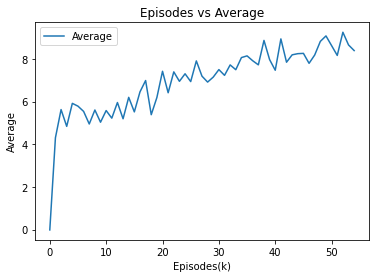

In [51]:
model = Policy()
env = Environment()
train(model, env)

Result Analysis(default; hidden_size=64): <br>
>The plot is not smooth but the general ascending trend is clearly there. This indicates that the model is learning to achieve higher reward. 

**Part5(b)** <br>
>The default hidden_size for the policy is currently 64. In the following section, I have tried to optimize the number of hidden units. First as a comparison, I attempted the hidden_size that is less than the current default hidden_size of 32. Next, I have increased the hidden_size to 128 and 256. 

Episode 0	Average return: 0.01
Episode 1000	Average return: 5.56
Episode 2000	Average return: 4.92
Episode 3000	Average return: 5.03
Episode 4000	Average return: 5.83
Episode 5000	Average return: 5.80
Episode 6000	Average return: 6.16
Episode 7000	Average return: 6.08
Episode 8000	Average return: 5.92
Episode 9000	Average return: 6.81
Episode 10000	Average return: 6.61
Episode 11000	Average return: 6.64
Episode 12000	Average return: 6.49
Episode 13000	Average return: 6.86
Episode 14000	Average return: 5.59
Episode 15000	Average return: 6.97
Episode 16000	Average return: 6.33
Episode 17000	Average return: 7.20
Episode 18000	Average return: 6.86
Episode 19000	Average return: 7.15
Episode 20000	Average return: 6.71
Episode 21000	Average return: 6.85
Episode 22000	Average return: 6.57
Episode 23000	Average return: 6.35
Episode 24000	Average return: 7.23
Episode 25000	Average return: 6.46
Episode 26000	Average return: 7.24
Episode 27000	Average return: 7.83
Episode 28000	Average return: 7.7

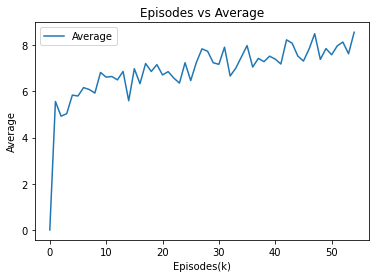

In [46]:
# hidden_size=32
model = Policy(hidden_size=32)
env = Environment()
train(model, env)

Result Analysis(hidden_size=32): <br>
>The plot is again not so smooth. Indeed it is slightly more noisy than the policy trained with 64 hidden units. Still the general ascending trend is maintained. 

Episode 0	Average return: -0.01
Episode 1000	Average return: 5.00
Episode 2000	Average return: 5.50
Episode 3000	Average return: 5.62
Episode 4000	Average return: 5.40
Episode 5000	Average return: 5.28
Episode 6000	Average return: 5.71
Episode 7000	Average return: 5.77
Episode 8000	Average return: 5.82
Episode 9000	Average return: 5.61
Episode 10000	Average return: 6.40
Episode 11000	Average return: 6.30
Episode 12000	Average return: 5.70
Episode 13000	Average return: 6.54
Episode 14000	Average return: 7.30
Episode 15000	Average return: 6.92
Episode 16000	Average return: 6.17
Episode 17000	Average return: 6.88
Episode 18000	Average return: 7.74
Episode 19000	Average return: 7.89
Episode 20000	Average return: 7.85
Episode 21000	Average return: 7.17
Episode 22000	Average return: 7.91
Episode 23000	Average return: 6.76
Episode 24000	Average return: 7.60
Episode 25000	Average return: 7.71
Episode 26000	Average return: 8.19
Episode 27000	Average return: 7.94
Episode 28000	Average return: 8.

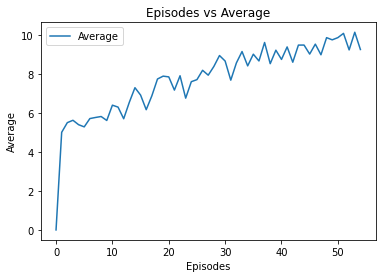

In [ ]:
# hidden_size=128
model = Policy(hidden_size=128)
env = Environment()
train(model, env)

Result Analysis(hidden_size=128): <br>
>The plot is still noisy. Though compared to the 32 hidden unit policy, it is less spiky. The general ascending trend is also still there. Also, comparing it to the 64 hidden unit policy model, it reaches average rewards over 10 and now 10 is included in the y axis as its range.  

Episode 0	Average return: 0.01
Episode 1000	Average return: 5.19
Episode 2000	Average return: 5.40
Episode 3000	Average return: 5.98
Episode 4000	Average return: 6.32
Episode 5000	Average return: 6.86
Episode 6000	Average return: 6.83
Episode 7000	Average return: 7.45
Episode 8000	Average return: 7.19
Episode 9000	Average return: 8.05
Episode 10000	Average return: 8.38
Episode 11000	Average return: 7.84
Episode 12000	Average return: 8.12
Episode 13000	Average return: 8.62
Episode 14000	Average return: 8.16
Episode 15000	Average return: 8.84
Episode 16000	Average return: 7.80
Episode 17000	Average return: 8.59
Episode 18000	Average return: 8.90
Episode 19000	Average return: 8.39
Episode 20000	Average return: 8.32
Episode 21000	Average return: 8.80
Episode 22000	Average return: 8.83
Episode 23000	Average return: 9.40
Episode 24000	Average return: 9.13
Episode 25000	Average return: 8.73
Episode 26000	Average return: 8.66
Episode 27000	Average return: 9.26
Episode 28000	Average return: 8.8

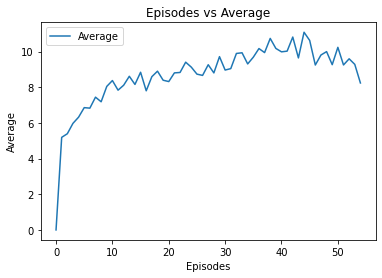

In [ ]:
model = Policy(hidden_size=256)
env = Environment()
train(model, env)

Result Analysis(hidden_size=256): <br>
> There is an interesting observation for the following plot. So far with 32, 64, and 128 hidden units, the general trend was ascending linear line. However, the average vs. episode plot for hidden_size of 256 has a concave shape. In fact this means the optimal weight was achieved by ~episode 40k. Such issue can be resolved through introduction of sliding window which if I do not see better rewards for certain number of episodes, I would stop training the model. 

**Part5(c)** <br>
I have modified the train function to count the number of invalid movies it makes by episode. 

In [32]:
def train(policy, env, gamma=1.0, log_interval=1000):
    """Train policy gradient."""
    #optimizer = optim.Adam(policy.parameters(), lr=0.001)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
    optimizer = optim.Adam(policy.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10000, gamma=0.9)
    running_reward = 0

    # ADDED VARIABLES
    EPOCHS = 55000
    avg = [] 
    # storing number of invalid_moves
    invalid_moves = [] 
 
    for i_episode in range(EPOCHS):
        invalid_move = 0
        saved_rewards = []
        saved_logprobs = []
        state = env.reset()
        done = False
        while not done:
            action, logprob = select_action(policy, state)
            state, status, done = env.play_against_random(action)
            if status == env.STATUS_INVALID_MOVE:
              invalid_move+=1 # count incrementation
            reward = get_reward(status)
            saved_logprobs.append(logprob)
            saved_rewards.append(reward)


        R = compute_returns(saved_rewards)[0]
        running_reward += R
        finish_episode(saved_rewards, saved_logprobs, gamma)

        if i_episode % log_interval == 0:
            print('Episode {}\tAverage return: {:.2f}, invalid_move_count: {}'.format(
                i_episode,
                running_reward / log_interval, invalid_move))
            invalid_moves.append(invalid_move) # append to store in invalid_moves
            avg.append(running_reward / log_interval)
            running_reward = 0

        if i_episode % (log_interval) == 0:
            torch.save(policy.state_dict(),
                       "./policy-%d.pkl" % i_episode)

        if i_episode % 1 == 0: # batch_size
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
    plt.title("Episodes vs Invalid_moves")
    plt.plot(invalid_moves, label="Invalid_moves")
    plt.xlabel("Episodes")
    plt.ylabel("Invalid_moves")
    plt.legend(loc='best')
    plt.show()

Episode 0	Average return: 0.01, invalid_move_count: 14
Episode 1000	Average return: 5.68, invalid_move_count: 7
Episode 2000	Average return: 5.61, invalid_move_count: 3
Episode 3000	Average return: 6.10, invalid_move_count: 13
Episode 4000	Average return: 5.98, invalid_move_count: 1
Episode 5000	Average return: 6.43, invalid_move_count: 0
Episode 6000	Average return: 6.87, invalid_move_count: 3
Episode 7000	Average return: 6.50, invalid_move_count: 0
Episode 8000	Average return: 7.64, invalid_move_count: 1
Episode 9000	Average return: 7.74, invalid_move_count: 4
Episode 10000	Average return: 7.62, invalid_move_count: 2
Episode 11000	Average return: 7.51, invalid_move_count: 1
Episode 12000	Average return: 7.85, invalid_move_count: 2
Episode 13000	Average return: 7.80, invalid_move_count: 1
Episode 14000	Average return: 8.07, invalid_move_count: 3
Episode 15000	Average return: 7.92, invalid_move_count: 2
Episode 16000	Average return: 7.79, invalid_move_count: 11
Episode 17000	Average re

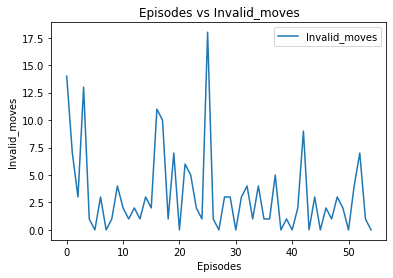

In [34]:
train(model, env)

Similar to how the averages were calculated and plotted, the number of invalid movies were counted each episodes and were stored in an array. Throughout the training process, the invalid move counts were printed. Then in the end, they were plotted for visual representation. 

The graph is very noisy but tracing either the troughs or the crests, the general descending trend can be observed. This indicates that the machine is learning to not make valid moves. By Episode 26000, the invalid move count seemed to stay fairly low. 

**Part 5(d)** <br>


In [58]:
def load_weights(policy, episode):
    """Load saved weights"""
    weights = torch.load("policy-%d.pkl" % episode)
    policy.load_state_dict(weights)

In [91]:
#initialize
win_count = 0
ties_count = 0
lose_count = 0
env = Environment()

#referenced the code from training
for i in range(100):
  state = env.reset()
  done = False
  while not done:
    action, logprob = select_action(model, state)
    state, status, done = env.play_against_random(action)

  #display last five games
  if i>=95: 
    env.render()
    print(status)
    print()

  #update count
  if status == env.STATUS_WIN:
    win_count+=1
  elif status == env.STATUS_TIE:
    ties_count+=1
  else:
    lose_count+=1
  

print()
print("Num of total_wins:", win_count)
print("Num of total_ties:", ties_count)
print("Num of total_loses:", lose_count)



xoo
xxo
oxx
====
win

xxo
oxx
oxo
====
win

x.x
ooo
xxo
====
lose

oxx
.x.
oxo
====
win

x.o
.x.
.ox
====
win


Num of total_wins: 64
Num of total_ties: 8
Num of total_loses: 28


I believe one strategy that my agent has learned is to take the very center on the game board. This is a great strategy in a Tic-Tac-Toe game. 

# **Part 6**

Game 0	 Win_rate 0.00, Ties_rate: 0.00, Lose_rate: 1.00
Game 1	 Win_rate 0.00, Ties_rate: 0.00, Lose_rate: 1.00
Game 2	 Win_rate 0.33, Ties_rate: 0.00, Lose_rate: 0.67
Game 3	 Win_rate 0.25, Ties_rate: 0.00, Lose_rate: 0.75
Game 4	 Win_rate 0.40, Ties_rate: 0.00, Lose_rate: 0.60
Game 5	 Win_rate 0.33, Ties_rate: 0.00, Lose_rate: 0.67
Game 6	 Win_rate 0.43, Ties_rate: 0.00, Lose_rate: 0.57
Game 7	 Win_rate 0.50, Ties_rate: 0.00, Lose_rate: 0.50
Game 8	 Win_rate 0.44, Ties_rate: 0.11, Lose_rate: 0.44
Game 9	 Win_rate 0.40, Ties_rate: 0.10, Lose_rate: 0.50
Game 10	 Win_rate 0.45, Ties_rate: 0.09, Lose_rate: 0.45
Game 11	 Win_rate 0.50, Ties_rate: 0.08, Lose_rate: 0.42
Game 12	 Win_rate 0.46, Ties_rate: 0.08, Lose_rate: 0.46
Game 13	 Win_rate 0.50, Ties_rate: 0.07, Lose_rate: 0.43
Game 14	 Win_rate 0.53, Ties_rate: 0.07, Lose_rate: 0.40
Game 15	 Win_rate 0.50, Ties_rate: 0.12, Lose_rate: 0.38
Game 16	 Win_rate 0.53, Ties_rate: 0.12, Lose_rate: 0.35
Game 17	 Win_rate 0.56, Ties_rate: 0.11, 

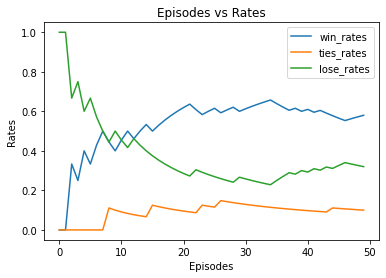

In [106]:
#initialize
win_count = 0
ties_count = 0
lose_count = 0

win_rates = []
ties_rates = []
lose_rates = []

env = Environment()

#referenced the code from training
for i in range(50):
  state = env.reset()
  done = False
  # the load function somehow complicated the colab so straight up copied the code
  weights = torch.load("policy-%d.pkl" % (i*1000))
  model.load_state_dict(weights)
  while not done:
    action, logprob = select_action(model, state)
    state, status, done = env.play_against_random(action)

  #display last five games
  if i>=95: 
    env.render()
    print(status)
    print()

  #update count
  if status == env.STATUS_WIN:
    win_count+=1
  elif status == env.STATUS_TIE:
    ties_count+=1
  else:
    lose_count+=1
  
  win_rate = win_count/(win_count+ties_count+lose_count)
  win_rates.append(win_rate)

  ties_rate = ties_count/(win_count+ties_count+lose_count)
  ties_rates.append(ties_rate)

  lose_rate = lose_count/(win_count+ties_count+lose_count)
  lose_rates.append(lose_rate)
  print('Game {}\t Win_rate {:.2f}, Ties_rate: {:.2f}, Lose_rate: {:.2f}'.format(
                i,win_rate, ties_rate, lose_rate))

print()
plt.title("Episodes vs Rates")
plt.plot(win_rates, label="win_rates")
plt.plot(ties_rates, label="ties_rates")
plt.plot(lose_rates, label="lose_rates")
plt.xlabel("Episodes")
plt.ylabel("Rates")
plt.legend(loc='best')
plt.show()



>As shown in the graph above, the win_rates goes up while the lose_rates goes down. The ties_rates seem to go up slightly. There is a strong trade off between win_rates and lose_rates. This tells that the model is learning to "win" the game.

#**Part 7: First Move Distirbution over Episodes**<br>


In [100]:
print(first_move_distr(model, env))

tensor([[0.6286, 0.0940, 0.3537, 0.1529, 0.8758, 0.1560, 0.5365, 0.1084, 0.3671]])


>I believe the dristribution makes sense. The distribution is the highest for position 4. On a 3x3 grid this is the center box. This is a well known strategy in playing a Tic-Tac-Toe that placing on the middle box is the best move on can take. This allows both defense and attack in all direction that this is the best position to play. The machine has learned and implemented it.


#**Part 8: Limitations** <br>

>My agent plays fairly well against a random policy. However, it does not perform so well when it does not have the center. This is also reflected in one lose case from the five printed game boards. Due to its high favoritism for the center, it has the strategy studied when that is the case. However, when the center is taken by the other player, it does not perform as well. 
